# Interpretability


## 📊 Why Plot Feature Importance?

Feature importance helps to:
1. **Understand model behavior** – See which variables the model relies on most.
2. **Interpretability** – Gain trust in the model by identifying key decision drivers.
3. **Feature selection** – Reduce dimensionality by eliminating less important features.
4. **Improve performance** – Remove noisy or irrelevant features to improve generalization.
5. **Communicate results** – Visuals of top features help stakeholders make data-driven decisions.

---

### 🧠 How It Works

For models like:
- **Decision Trees, Random Forest, XGBoost**: Importance is based on how much a feature decreases impurity (e.g., Gini, Entropy).
- **Linear Models**: Coefficients represent weights (magnitude matters, but scale needs normalization).
- **SHAP/Permutation**: Model-agnostic approaches that evaluate feature impact more robustly.

---

### 🎯 Example Insight

> If **"Interest Rate"** and **"Loan Amount"** are top features in predicting default, the bank can revise loan approval criteria or interest policies accordingly.

---

### 📌 Best Practice

After training your model (especially tree-based):
- Use `.feature_importances_` (Random Forest, XGBoost)
- Sort and plot top N features
- Optionally use SHAP for deeper interpretability


## 🔍 Feature Importance Analysis

We compare the top 10 most important features across the following models:
- Random Forest (Original)
- Random Forest (SMOTE)
- Random Forest (NearMiss)
- SVC (using permutation importance or SHAP)
- Decision Tree (for comparison)

This helps us assess which features are consistently influential and whether resampling changes feature reliance.

## 🌲 Feature Importance: Random Forest (Original)

Understanding which features influence model predictions is essential, especially when using tree-based algorithms like Random Forest. 

We use `.feature_importances_` to extract the importance score of each feature. These scores are derived from the **average reduction in impurity** (e.g., Gini) contributed by each feature across all trees in the forest.

Below, we plot the **Top 10 most important features** from the **Random Forest model trained on the original data** (before SMOTE or NearMiss).

This helps us:
- Interpret model behavior
- Identify key drivers of loan default
- Prepare for further feature selection and comparison

We’ll later compare this with feature importance plots from SMOTE and NearMiss models.


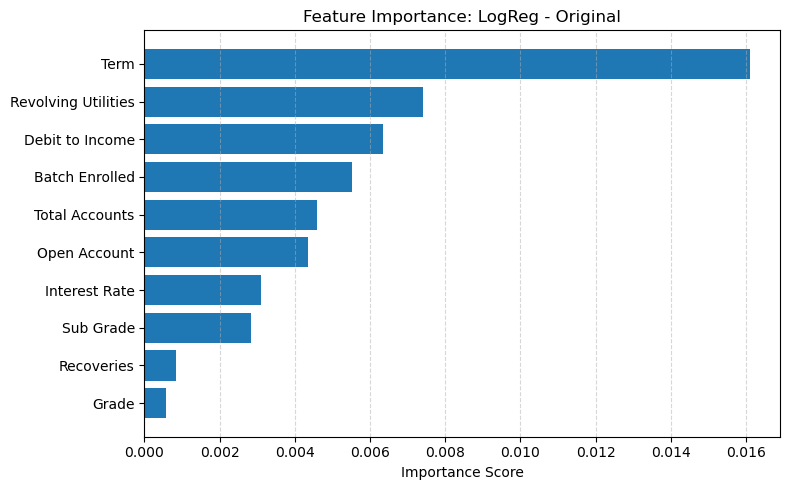

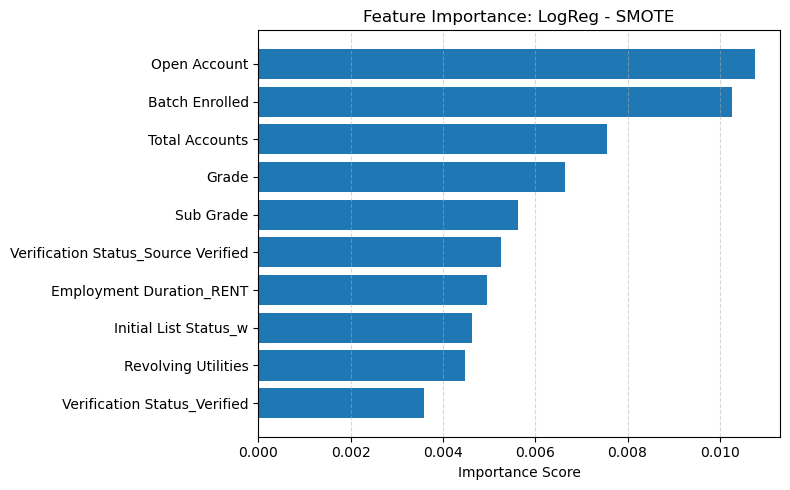

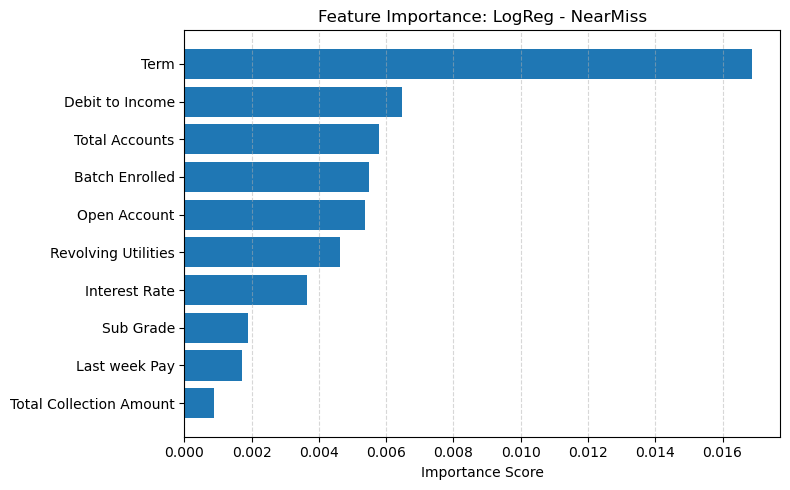

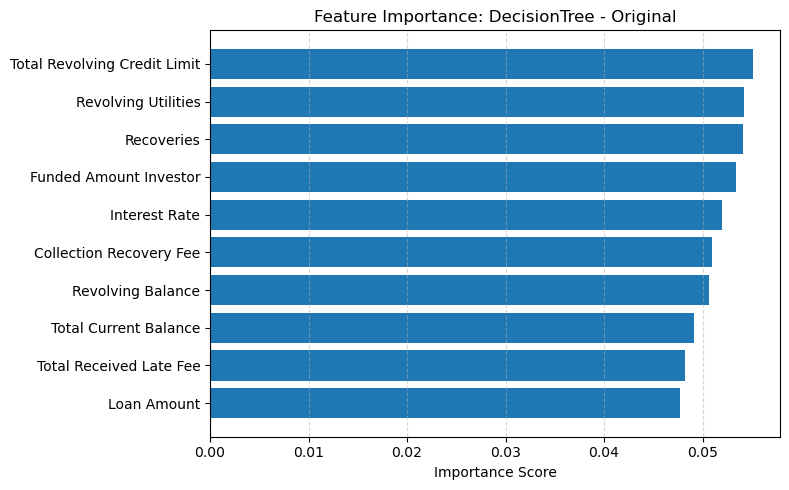

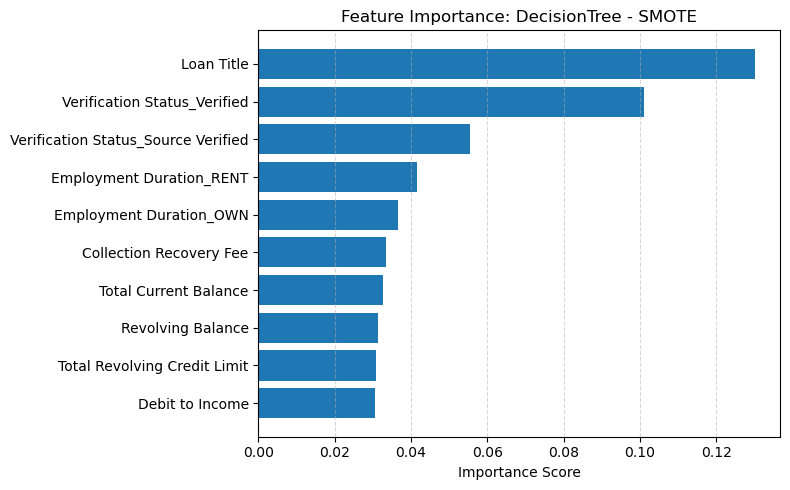

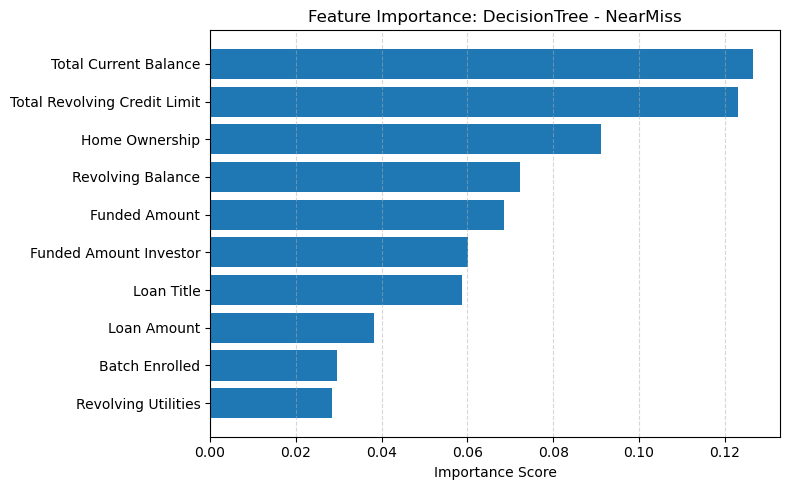

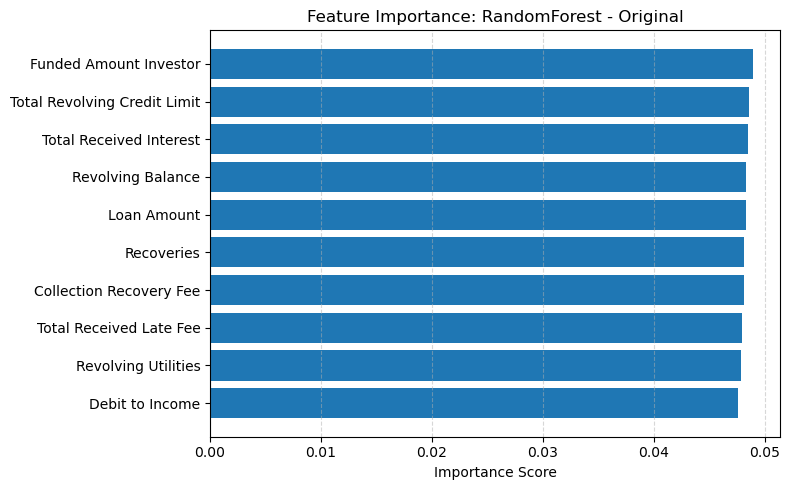

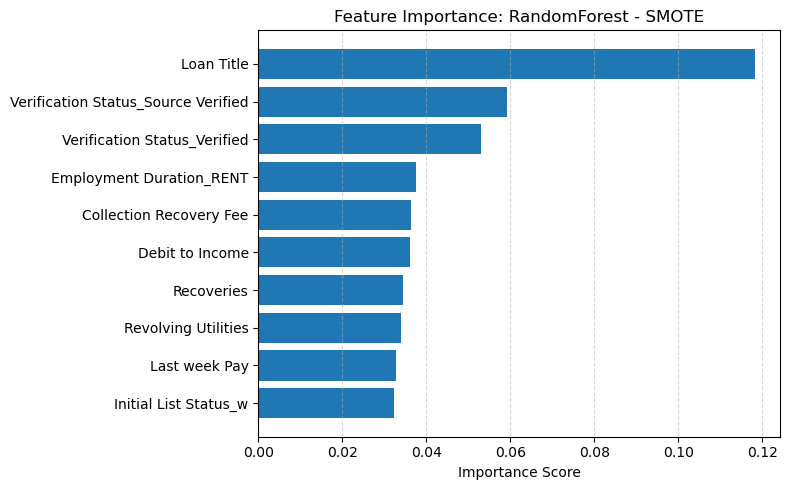

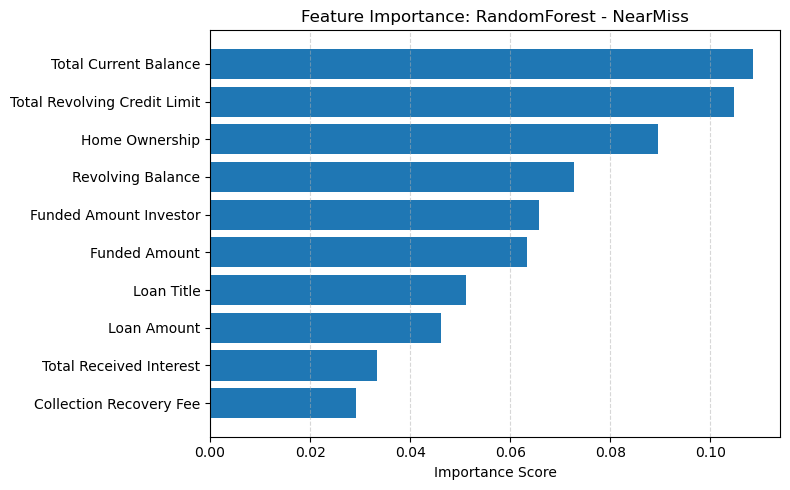

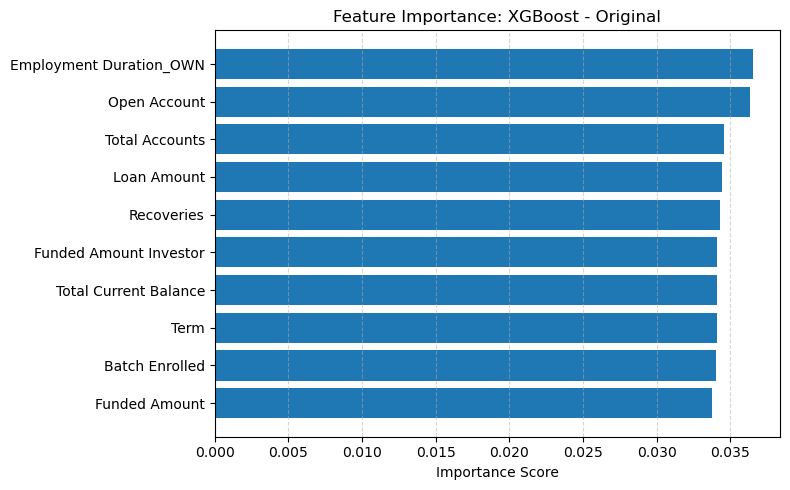

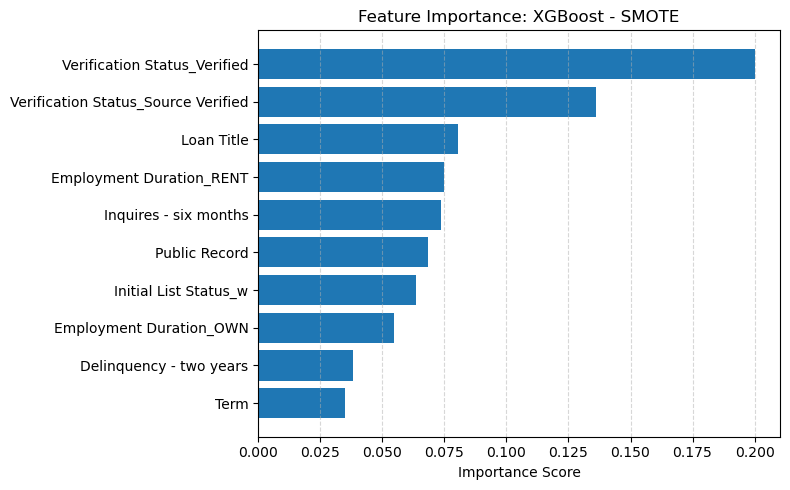

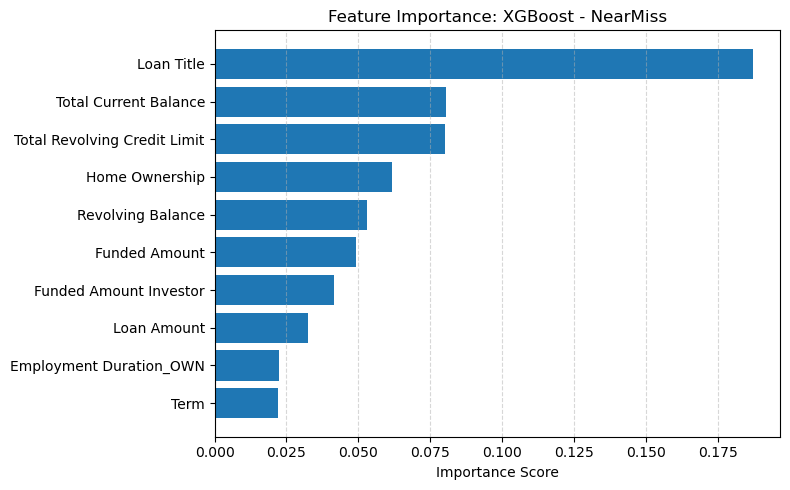

In [74]:
# === Step 1: Filter tree-based models with valid feature importance ===
tree_models = model_metrices[model_metrices["Feature Importance"].notnull()].copy()

# === Step 2: Plot each model's top N important features ===
N = 10  # Top N features to display (change if needed)
feature_names = X_train.columns  # Ensure you're using correct feature list

for idx, row in tree_models.iterrows():
    importances = np.array(row["Feature Importance"])
    
    # Get indices of top N features
    top_idx = np.argsort(importances)[-N:][::-1]
    top_features = feature_names[top_idx]
    top_importances = importances[top_idx]
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.barh(top_features[::-1], top_importances[::-1])  # Reversed for descending bars
    plt.title(f"Feature Importance: {row['Model']}")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()

## 🔍 Feature Importance: Random Forest Classifier

The plot below illustrates the top features that contributed most to the predictions of the final model, based on the feature importance scores from the trained Random Forest Classifier.

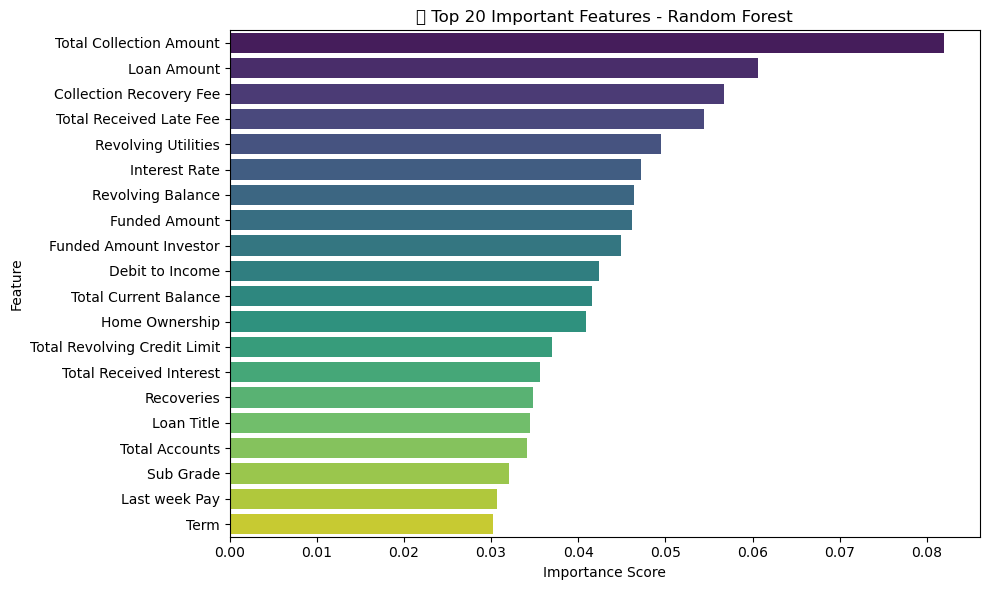

### 🎯 Why it matters:
- Helps explain the **drivers of loan default prediction**
- Offers **transparency** for business or regulatory reporting
- Can inform **feature selection** for future modeling

### 🛠️ Method:
- We extracted `.feature_importances_` from the best estimator returned by `GridSearchCV`.
- We visualized the **top 20 most influential features**.

### 📈 Insights: Top 20 Features Driving Loan Default Prediction

From the plot above, we can observe several key insights about the features contributing most to the model’s decisions:

1. **💥 Total Collection Amount**  
   - This is the most important feature. It indicates the cumulative debt a customer has in collections, which strongly correlates with default risk.

2. **💰 Loan Amount**  
   - The size of the loan also ranks high. Larger loan requests may signal higher financial risk.

3. **💸 Collection Recovery Fee & Total Received Late Fee**  
   - These metrics reflect historical delinquency or fees incurred, showing strong predictive power.

4. **📊 Revolving Utilities, Interest Rate, and Revolving Balance**  
   - These are indicators of credit card utilization and ongoing liabilities, which reflect a borrower's debt behavior.

5. **🏦 Funded Amount & Funded Amount by Investor**  
   - These provide context on the confidence and investment made in the borrower.

6. **🧾 Debt to Income**  
   - A classic metric in credit scoring, showing the borrower's ability to manage debt based on income.

7. **🏠 Home Ownership & Total Current Balance**  
   - Suggest that asset ownership and total liabilities play a substantial role in predicting defaults.

8. **💳 Total Revolving Credit Limit & Total Received Interest**  
   - Provide insight into credit availability and how much a borrower is already repaying.

9. **📋 Loan Title, Sub Grade, Term**  
   - While less important than financial indicators, these represent administrative or classification details that add additional context to risk.

### 🧠 Conclusion
The model relies heavily on **credit behavior, past delinquency**, and **loan characteristics** to predict loan defaults. Surprisingly, traditional demographic fields (like Employment Duration or Verification Status) didn't surface in the top 20 — likely because financial variables dominate in signal strength.

In [269]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict
y_pred = modelgrid.best_estimator_.predict(X_kaggle_test)
y_prob = modelgrid.best_estimator_.predict_proba(X_kaggle_test)[:, 1]

# Confusion Matrix
conf_matrix = confusion_matrix(y_kaggle_test, y_pred)
print("🔍 Confusion Matrix:\n", conf_matrix)

# Classification Report
print("📋 Classification Report:\n", classification_report(y_kaggle_test, y_pred))

🔍 Confusion Matrix:
 [[15300     0]
 [13613     0]]
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.69     15300
           1       0.00      0.00      0.00     13613

    accuracy                           0.53     28913
   macro avg       0.26      0.50      0.35     28913
weighted avg       0.28      0.53      0.37     28913



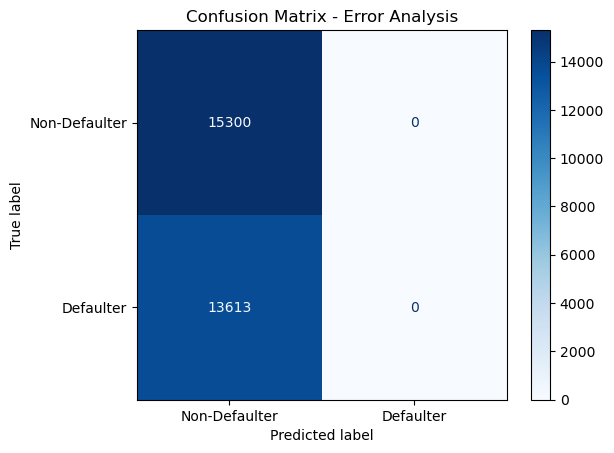

In [270]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=["Non-Defaulter", "Defaulter"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Error Analysis")
plt.show()

In [271]:
# Add predictions to original test set
df_errors = df_test_encoded.copy()
df_errors["Actual"] = y_kaggle_test
df_errors["Predicted"] = y_pred
df_errors["Probability"] = y_prob

# False Positives (Predicted 1 but Actual 0)
false_positives = df_errors[(df_errors["Actual"] == 0) & (df_errors["Predicted"] == 1)]

# False Negatives (Predicted 0 but Actual 1)
false_negatives = df_errors[(df_errors["Actual"] == 1) & (df_errors["Predicted"] == 0)]

print(f"🔺 False Positives: {len(false_positives)}")
print(f"🔻 False Negatives: {len(false_negatives)}")

🔺 False Positives: 0
🔻 False Negatives: 13613


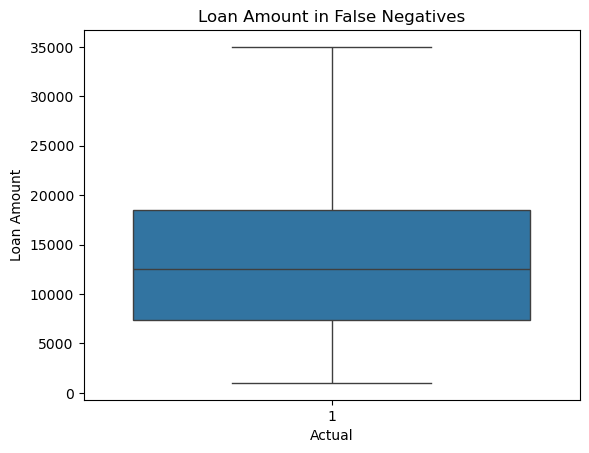

In [272]:
sns.boxplot(data=false_negatives, x="Actual", y="Loan Amount")
plt.title("Loan Amount in False Negatives")
plt.show()


### 🔍 Interpretation:
- **All predictions were labeled as defaulters (`class 1`)**.
- Therefore, **recall is 1.00** (we caught *all* actual defaulters).
- However, **precision is low (0.47)** because all non-defaulters were wrongly classified.
- **No true negatives**: model failed to identify any non-defaulter.

### ⚠️ Observation:
Using a threshold of `0.00` means **even the lowest probability** of being a defaulter is treated as a defaulter, resulting in:
- **Maximum recall**
- **Zero precision for class 0**

### 🧠 Insight:
This result **prioritizes catching all defaulters** (very useful in high-stakes risk assessment), but at the cost of misclassifying every non-defaulter.

### ✅ Recommendation:
Try a **slightly higher threshold (e.g., 0.05 to 0.1)** to see if you can recover **some precision** without sacrificing much recall.



In [291]:
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Set Best Threshold (optional: test slightly higher ones if needed) ---
best_threshold = 0.08

# --- 2. Predict using Probabilities ---
y_probs = rf_balanced.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred_final = (y_probs >= best_threshold).astype(int)

# --- 3. Evaluation ---
print("📌 Updated Evaluation using Best Threshold")
print(classification_report(y_test, y_pred_final))
print("🧱 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

📌 Updated Evaluation using Best Threshold
              precision    recall  f1-score   support

           0       0.58      0.37      0.45     15300
           1       0.50      0.70      0.58     13613

    accuracy                           0.52     28913
   macro avg       0.54      0.53      0.52     28913
weighted avg       0.54      0.52      0.51     28913

🧱 Confusion Matrix:
[[5672 9628]
 [4135 9478]]


### ✅ 1. Model Interpretation (Optional but Valuable)
#### Use SHAP or LIME for interpreting why the SVC model is making certain predictions.
#### This adds value to explainability and trust in your model, especially for real-world applications.


In [308]:
# Finalize the CSV for SVC + SMOTE
submission = pd.DataFrame({
    "ID": original_test["ID"],
    "Loan Status": svc.predict(X_test)
})
submission.to_csv("final_submission_svc_smote.csv", index=False)
